In [31]:
### MPE CDT Machine Learning Project w/ Met Office ###
# A small project for experimenting with machine learning for interpolating
# weather data.
#
# Essentially, can we make fewer observations and run coarser simulations,
# and use machine learning to interpolate between them?
#
# Makes for a nice introduction to machine learning. See the code below for
# expected usage of much of this - it's simple enough that we didn't take
# the time to write intricate docstrings!
#
# The overall results seem to be that super-basic linear interpolation is
# actually working better than any of the (compeletely arbitrarily chosen)
# machine learning algorithms. This is likely because the data is already
# at a very coarse resolution, so it is already pretty smooth - there is
# little to be gained by trying to do something clever! Ideally we'd be
# using smaller-scaler data.

In [32]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

In [33]:
import sklearn.base as skb
import sklearn.ensemble as ske
import sklearn.linear_model as sklm
import sklearn.model_selection as skms
import sklearn.neighbors as skn
import sklearn.pipeline as  skpi
import sklearn.preprocessing as skpr

In [34]:
# Helper functions for getting and plotting data

class DataGetter:
    """Gets data and artifically coarsens it for training the machine."""
    
    def __init__(self):
        self.temp_data = netCDF4.Dataset("data/erai_t2m_daily.nc")
        self.precip_data = netCDF4.Dataset("data/erai_tp_daily.nc")
        
    def retrieve_fine_data(self, dataset='t2m', t=0, region=None):
        """Returns the data for a particular dataset, at a particular time, for a
        particular region of the world.
        
        :string dataset: Either 't2m' or 'tp', corresponding to temperature and
            precipitation respectively.
        :int t: Nonnegative integer specifying which timeslice through the data to use.
        :(int, int, int, int)|None region: The region of the world to look at. Defaults
            to None, which is the entire world. If using integers, then it should be
            ordered as xmin, xmax, ymin, ymax. The x values should be between 0 and 511,
            the y values should be between 0 and 255.
            
        :return: The particular portion of the dataset requested."""
        
        if dataset in ('temp', 'temperature', 't2m'):
            data = self.temp_data
            data_name = 't2m'
        elif dataset in ('precip', 'precipitation', 'tp'):
            data = self.precip_data
            data_name = 'tp'
        else:
            raise Exception('Unknown dataset {}'.format(dataset))
            
        # -1 because the y-axis is flipped in the data
        return_data = np.array(data.variables[data_name][t, ::-1, :])
        if region is None:
            return return_data
        else:
            xmin, xmax, ymin, ymax = region
            return return_data[ymin:ymax, xmin:xmax]

    @staticmethod
    def coarsen(f_data, sep=2):
        """Coarsens the fine data that it is given down to coarse data. It will keep
        one in sep**2 pieces of data.
        
        :numpy.array f_data: The fine data returned by the retrieve_fine_data method.
        :int sep: Positive Integer specifying the x, y separation betwen those data
            points which are kept.
            
        :return: The coarsened data."""
        
        return f_data[::sep, ::sep]


class Plotter:
    """Wrapper around helper functions for plotting."""
    
    @staticmethod
    def plot_data(data, region=None, cmap=plt.get_cmap('jet')):
        """Plots the data in a particular region.
        
        :numpy.array data: The data to be plotted. Expected to be a 2D array
            corresponding to temperature or precipitation data for the region.
        :(int, int, int, int)|None region: The region to be plotted. See
            DataGetter.retrieve_fine_data docstring. Defaults to the entire dataset.
        :cmap cmap: The colormap, as for pyplot. Defaults to 'jet'."""
        
        plt.pcolormesh(data, cmap=cmap)
        plt.colorbar()
        if region is not None:
            xmin, xmax, ymin, ymax = region
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        plt.show()
        
    @classmethod
    def plot_diff(cls, p_data, f_data, region=None, cmap=plt.get_cmap('jet')):
        """Plots the difference between two different datasets.
        
        :nump.array p_data: As for the data argument of plot_data.
        :numpy.arraya f_data: As for the data argument of plot_data.
        :(int, int, int, int)|None region: The region to be plotted. See
            DataGetter.retrieve_fine_data docstring. Defaults to the entire dataset.
        :cmap cmap: The colormap, as for pyplot. Defaults to 'jet'."""
        
        cls.plot_data(p_data - f_data, region, cmap=cmap)


# Should work regardless what array shape p_dat and f_data are, as long as their shapes are the same.
def rms(p_data, f_data):
    """The RMS between two different numpy arrays.
    
    :numpy.array p_data:
    :numpy.array f_data: Two numpy arrays of the same shape."""
    
    diff = np.array(p_data) - np.array(f_data)
    return np.sqrt(np.mean(np.square(diff)))
                   
def l2(p_data, f_data):
    """The L2 norm between two different numpy arrays.
    
    :numpy.array p_data:
    :numpy.array f_data: Two numpy arrays of the same shape."""
                   
    diff = np.array(p_data) - np.array(f_data)
    return np.sqrt(np.sum(np.square(diff)))

In [35]:
# Helper functions for preprocessing the data.

class _BaseTransformer(skb.TransformerMixin, skb.BaseEstimator):
    """DRY for Reshaper, Binner."""
    def fit(self, X, y=None):
            return self

class Reshaper(_BaseTransformer):
    """Reshapes the data from two dimensions down to one."""  # Needed for KNeighbours later.
    def transform(self, X, y=None):
            return np.array([x.reshape(-1) for x in X])
        
    def inverse_transform(self, X, y=None):
        return np.array([x.reshape(256, 512) for x in X])  # Hardcoded for now
     
    
class Binner(_BaseTransformer):
    """Classifies the data into bins, i.e. going continuous -> discrete."""
    def transform(self, X, y=None):
            return np.array([[np.int(100 * y) for y in x]  for x in X])
        
    def inverse_transform(self, X, y=None):
        return np.array([[y/100 for y in x] for x in X])
    
pipe = skpi.Pipeline([('reshaper', Reshaper()),
                      ('minmax_scaler', skpr.MinMaxScaler()),
                      ('binner', Binner()),
                     ])

In [36]:
# Sample region for zooming in on
xmin, xmax, ymin, ymax = region = (430, 490, 210, 240)

# tp or t2m for precipitation/temperature respectively
dataset = 't2m'
# We keep one out of sep**2 of the grid points when coarsening
sep = 10
# What proportion of the data to set aside for testing the machine
test_size = 0.2
# How many pieces of data we use in total, between both training and testing
timerange = 100

# Unprepared fine and coarse data
fine_data = []
coarse_data = []

data_getter = DataGetter()

for timestamp in range(timerange):
    f_data = data_getter.retrieve_fine_data(dataset, timestamp)
    c_data = data_getter.coarsen(f_data, sep)
    fine_data.append(f_data)
    coarse_data.append(c_data)
    
# The shape of the fine and predicted data
f_shape = fine_data[0].shape
    
# Unprepared fine and coarse data, split into training and testing
unprep_train_coarse, unprep_test_coarse, unprep_train_fine, unprep_test_fine = skms.train_test_split(coarse_data, fine_data, test_size=test_size, random_state=42)

In [37]:
# Prepared fine and coarse data. May take a short amount of time.
train_coarse = pipe.fit_transform(unprep_train_coarse)
test_coarse = pipe.fit_transform(unprep_test_coarse)
train_fine = pipe.fit_transform(unprep_train_fine)
test_fine = pipe.fit_transform(unprep_test_fine)

In [38]:
def test_ml(ml, indices, prepared=True, inp='test'):
    """Tests a given machine on a particular piece of data. (Note that
    this function implicitly depends on the data created earlier in 
    this notebook.)
    
    :ml: The fitted machine learning algorithm.
    :iter(int)|int indices: Which pieces of data to test the algorithm
        on.
    :bool prepared: Whether the algorithm uses the prepared data or the
        unprepared data.
    :string inp: Should be 'test' or 'train'. Specifies whether the
        algorithm should be tested against the testing or the training
        data.
        
    Returns nothing. Prints out the RMS and L2 norm of the predictions
    against observations. If indices specifies only one datapoint then
    it will plot the input data, prediction, observation, and difference
    between prediction and observation."""
    
    try:
        indices = list(indices)
    except TypeError:  # indices isn't an iterable
        indices = [indices]
        
    if inp == 'train':
        u_f_data = np.array([unprep_train_fine[i] for i in indices])
        u_c_data = np.array([unprep_train_coarse[i] for i in indices])
        c_data = np.array([train_coarse[i] for i in indices])
    elif inp == 'test':
        u_f_data = np.array([unprep_test_fine[i] for i in indices])
        u_c_data = np.array([unprep_test_coarse[i] for i in indices])
        c_data = np.array([test_coarse[i] for i in indices])
    else:
        raise Exception
        
    if not prepared:
        c_data = u_c_data
        
    p_data = ml.predict(c_data)
    
    if prepared:
        u_p_data = pipe.inverse_transform(p_data)
    else:
        u_p_data = p_data
        
    if len(indices) == 1:
        print("Input:")
        Plotter.plot_data(u_c_data[0])
        print("Prediction:")
        Plotter.plot_data(u_p_data[0])
        print("Observation:")
        Plotter.plot_data(u_f_data[0])
        print("Prediction - Observation:")
        Plotter.plot_diff(u_p_data[0], u_f_data[0])
    rmss = [rms(p_data, f_data) for p_data, f_data in zip(u_p_data, u_f_data)]
    l2s = [l2(p_data, f_data) for p_data, f_data in zip(u_p_data, u_f_data)]
    if len(indices) < 20:
        print("RMS: ", rmss)
        print("L2: ", l2s)
    print("Mean RMS: ", np.mean(rmss))
    print("Mean L2: ", np.mean(l2s))  # ...essentially a mixed L1-L2 norm now

In [39]:
class Interpolator:
    """Basic 2D local linear interpolation. Written to coincide with the
    structure of the other machine learning algorithms supplied by sklearn.
    
    Essentially constructs the piecewise linear function through the given
    data points.
    
    Note that is uses *unprepared* training data."""
    
    def __init__(self, f_shape, sep):
        self._f_shape = f_shape
        self._sep = sep
    
    @staticmethod
    def interpolater_wrapper(interpolate_func):
        """Offers a general framework for calculating interpolated values."""  # Even if we only ever actually end up using it once...
        def interpolater_inner(self, c_data):
            return_data = np.empty(self._f_shape, dtype=np.float32)
            for y in range(self._f_shape[0]):
                for x in range(self._f_shape[1]):
                    return_data[y, x] = interpolate_func(x, y, c_data)
            return return_data
        return interpolater_inner

#     def _zero_func(self, x, y, c_data):
#         if y % sep == 0 and x % sep == 0:  # Known data
#             return c_data[y // sep, x // sep]
#         else:
#             return 0

#     separate_data = local_interpolater.__func__(_zero_func)

    def _mean_func(self, x, y, c_data):
        """Linearly interpolates between the points of c_data to determine the value at (x, y)."""
        
        c_shape = c_data.shape
        prop_x = (x % self._sep) / self._sep
        prop_y = (y % self._sep) / self._sep
        
        # We take modulo on the x direction because that correspons to going around the world;
        # it makes sense to use data from the other side.
        # For the y axis, we apply a minimum to limit things to use the best data we have when we get to the edge of the data
        return (
                (1 - prop_x) * (1 - prop_y) * c_data[y // self._sep, x // self._sep] + 
                prop_x       * (1 - prop_y) * c_data[y // self._sep, (1 + x // self._sep) % c_shape[1]] +        
                (1 - prop_x) * prop_y       * c_data[min(c_shape[0] - 1, 1 + y // self._sep), x // self._sep] +
                prop_x       * prop_y       * c_data[min(c_shape[0] - 1, 1 + y // self._sep), (1 + x // self._sep) % c_shape[1]]
               )
    
    def fit(self, X, y=None):
        return self
    
    def predict(self, Xs):
        averager = self.interpolater_wrapper(self._mean_func)
        return [averager(self, X) for X in Xs]

In [40]:
# Test linear interpolation to give us a benchmark.

lininp = Interpolator(f_shape, sep)
lininp.fit(unprep_train_coarse, unprep_train_fine);  # Doesn't actually do anything

In [41]:
test_ml(lininp, range(10), prepared=False)  # Test against the first ten pieces of test data

RMS:  [2.4668887, 2.3519363, 2.3948543, 2.438701, 2.4777715, 2.340139, 2.2934008, 2.3928943, 2.326362, 2.2934299]
L2:  [893.1091, 851.4919, 867.0299, 882.90405, 897.04913, 847.22076, 830.29974, 866.32025, 842.23303, 830.31036]
Mean RMS:  2.3776379
Mean L2:  860.79675


In [42]:
# Try out algorithm number one

knn_clf = skn.KNeighborsClassifier()
knn_clf.fit(train_coarse, train_fine);

In [43]:
test_ml(knn_clf, range(10))  # Test against the first ten pieces of test data

RMS:  [3.9076646796065, 3.2471234203582835, 3.471867186810601, 3.7548117269747676, 3.8511426564796043, 3.1635334415435166, 3.380609263801938, 3.630555486602637, 3.278517359671318, 4.2101121489246065]
L2:  [1414.7257310990917, 1175.5842508211192, 1256.9501855604929, 1359.3870511219864, 1394.2625729093136, 1145.3214459012286, 1223.911288307923, 1314.4014868739841, 1186.950070917839, 1524.2234112309538]
Mean RMS:  3.589593737077377
Mean L2:  1299.5717494743933


In [44]:
# Try out algorithm number two

rf_reg = ske.RandomForestRegressor()
rf_reg.fit(train_coarse[70:90], train_fine[70:90]);  # Run on a smaller dataset because this one is slow

In [45]:
test_ml(rf_reg, range(10))  # Test against the first ten pieces of test data

RMS:  [4.8436547047073475, 3.9343610423473203, 2.834440550917796, 4.222748964276978, 4.259804285991095, 4.784363874635458, 3.92620727125744, 4.149014797935379, 5.332364629432284, 6.205305049123463]
L2:  [1753.5903167614413, 1424.3908468121415, 1026.177092825143, 1528.7984270790255, 1542.213886541733, 1732.124743382363, 1421.4388663552338, 1502.1038074180813, 1930.5222088862001, 2246.560399137957]
Mean RMS:  4.449226517062456
Mean L2:  1610.792059519932


In [47]:
# Result: the two machine learning algorithms don't work terribly well!
# Not a great surprise, given how naively they were applied, how smooth
# the given data is, how little data they were given to use and how little
# time they were given to run... !

# Let's have some pretty pictures...
# The x, y scale is a partition of the Earth's surface. The color
# represents the temperature (in Kelvin?) In particular the color
# of the prediction-observation map shows the difference in temperature
# between the two.

Input:


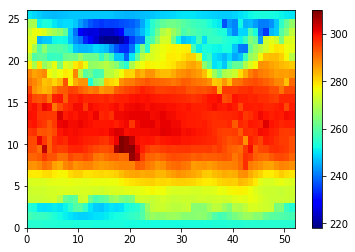

Prediction:


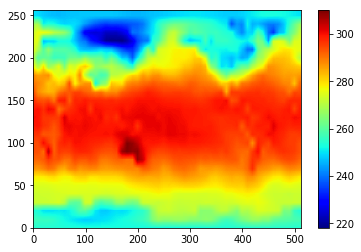

Observation:


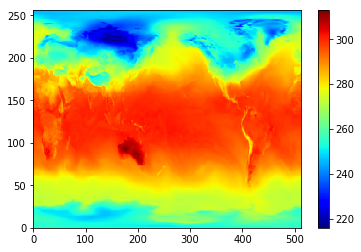

Prediction - Observation:


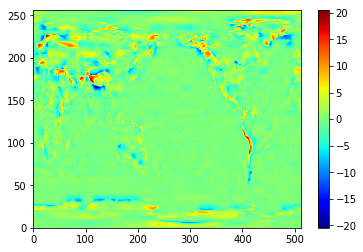

RMS:  [2.1501496]
L2:  [778.4373]
Mean RMS:  2.1501496
Mean L2:  778.4373


In [50]:
# Test linear interpolation against test data #15
test_ml(lininp, 15, prepared=False)

Input:


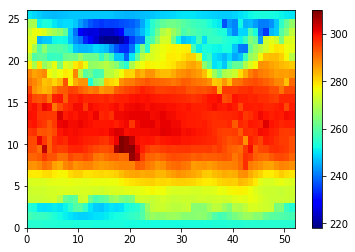

Prediction:


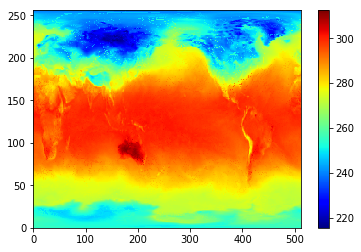

Observation:


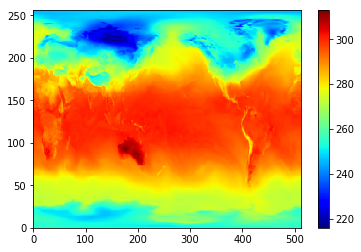

Prediction - Observation:


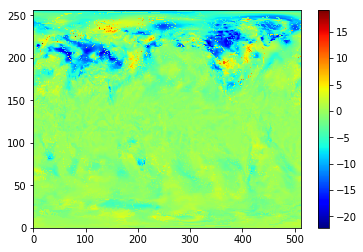

RMS:  [3.4267632456468875]
L2:  [1240.6208146010813]
Mean RMS:  3.4267632456468875
Mean L2:  1240.6208146010813


In [51]:
# Test KNeighbours against test data #15
test_ml(knn_clf, 15)

Input:


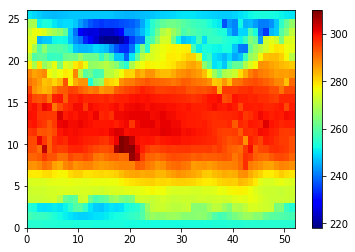

Prediction:


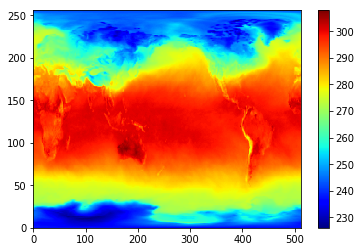

Observation:


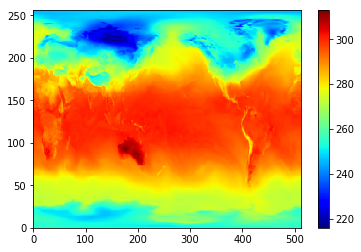

Prediction - Observation:


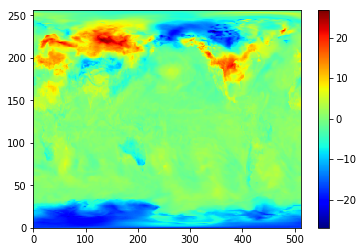

RMS:  [6.206446386474432]
L2:  [2246.9736073967692]
Mean RMS:  6.206446386474432
Mean L2:  2246.9736073967692


In [52]:
# Test RandomForestRegressor against test data #15
test_ml(rf_reg, 15)